# Network Visualization

In [36]:

import os
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
import networkx as nx
from pyvis.network import Network
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import pyvis
import jinja2

def check_dependencies():
    """Check pyvis and jinja2 versions and template file."""
    try:
        pyvis_version = pyvis.__version__
        print(f"Using pyvis version: {pyvis_version}")
        if tuple(map(int, pyvis_version.split('.'))) < (0, 3, 1):
            print("Warning: pyvis version < 0.3.1 detected. Consider upgrading with 'pip install --upgrade pyvis'.")
    except Exception as e:
        print(f"Error checking pyvis version: {e}")
    
    try:
        jinja2_version = jinja2.__version__
        print(f"Using jinja2 version: {jinja2_version}")
    except Exception as e:
        print(f"Error: jinja2 not installed or inaccessible: {e}. Install with 'pip install jinja2'.")
        return False
    
    try:
        template_path = os.path.join(os.path.dirname(pyvis.__file__), 'templates', 'template.html')
        if not os.path.exists(template_path):
            print(f"Warning: pyvis template file not found at {template_path}. Using cdn_resources='remote' to bypass.")
        else:
            print(f"Found pyvis template at {template_path}")
    except Exception as e:
        print(f"Error checking pyvis template: {e}")
    
    return True

def load_model_and_subtopics(platform, label, custom_names):
    """Load BERTopic model and subtopic info with topic embeddings."""
    path = os.path.join(os.getcwd(), 'data', f'{platform}_data', 'berttopic_label', label)
    try:
        topic_model = BERTopic.load(os.path.join(path, f'{label}_berttopic'))
    except Exception as e:
        print(f"Error loading model for label '{label}': {e}")
        return []
    
    topic_info = topic_model.get_topic_info()
    topic_keywords = {t: topic_model.get_topic(t) for t in topic_info.Topic if t != -1}
    doc_counts = topic_info.set_index("Topic")["Count"].to_dict()
    total_label_docs = sum([count for tid, count in doc_counts.items() if tid != -1])
    
    topic_embeddings = topic_model.topic_embeddings_
    topic_ids = sorted([t for t in topic_keywords.keys()])
    if len(topic_embeddings) != len(topic_info):
        print(f"Warning: Mismatch between topic embeddings ({len(topic_embeddings)}) and topics ({len(topic_info)}) for label '{label}'.")
    
    subtopics = []
    for topic_id in topic_ids:
        keywords = [(kw, score) for kw, score in topic_keywords[topic_id]]
        doc_indices = [i for i, t in enumerate(topic_model.topics_) if t == topic_id]
        if not doc_indices:
            print(f"Warning: No documents assigned to topic {topic_id} in label '{label}'.")
            continue
        embedding_idx = topic_id + 1 if topic_id >= 0 else 0
        if embedding_idx >= len(topic_embeddings):
            print(f"Warning: No embedding for topic {topic_id} in label '{label}'.")
            continue
        subtopics.append({
            'model_label': label,
            'topic_id': topic_id,
            'name': custom_names.get(topic_id, f"{label}_{topic_id}"),
            'keywords': keywords,
            'doc_indices': doc_indices,
            'doc_count': doc_counts.get(topic_id, 0),
            'embedding': topic_embeddings[embedding_idx],
            'total_label_docs': total_label_docs
        })
    
    return subtopics

def matplotlib_fallback(G, all_subtopics, pos, labels, label_color):
    """Fallback visualization using matplotlib."""
    plt.figure(figsize=(22, 18))
    
    node_sizes = [G.nodes[n]['size'] * 15000 for n in G.nodes]
    node_colors = [label_color[all_subtopics[n]['model_label']] for n in G.nodes]
    
    edge_weights = []
    if G.edges:
        min_sim = min(G[u][v]['weight'] for u, v in G.edges)
        max_sim = max(G[u][v]['weight'] for u, v in G.edges)
        edge_weights = [((G[u][v]['weight'] - min_sim) / (max_sim - min_sim + 1e-6)) * 5 + 0.5 for u, v in G.edges]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.4)
    nx.draw_networkx_labels(G, pos, labels={n: all_subtopics[n]['name'] for n in G.nodes}, font_size=10)
    
    for node, (x, y) in pos.items():
        plt.text(x, y - 0.1, f"{all_subtopics[node]['doc_count']}", fontsize=10, ha='center', color='gray')
    
    legend_handles = [
        mpatches.Patch(color=label_color[label], label=label)
        for label in labels
    ]
    plt.legend(handles=legend_handles, loc="upper right", fontsize=12, title="Main Topics", title_fontsize=13)
    
    plt.title("Network of Subtopics across Mental Health Topics (Normalized)", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    output_path = os.path.join(os.getcwd(), "subtopics_network_fallback.png")
    plt.savefig(output_path)
    plt.close()
    print(f"Fallback visualization saved to {output_path}")

def manual_html_render(net, output_path):
    """Manually render HTML if pyvis fails."""
    try:
        # Basic HTML template with vis.js
        html_template = """
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <title>3D Network Visualization</title>
            <script type="text/javascript" src="https://unpkg.com/vis-network@9.1.2/dist/vis-network.min.js"></script>
            <style type="text/css">
                #mynetwork {
                    width: 100%;
                    height: 750px;
                    border: 1px solid lightgray;
                }
            </style>
        </head>
        <body>
        <div id="mynetwork"></div>
        <script type="text/javascript">
            var nodes = new vis.DataSet({nodes_data});
            var edges = new vis.DataSet({edges_data});
            var container = document.getElementById('mynetwork');
            var data = {{ nodes: nodes, edges: edges }};
            var options = {options_data};
            var network = new vis.Network(container, data, options);
        </script>
        </body>
        </html>
        """
        nodes_data = [
            {
                "id": idx,
                "label": topic['name'],
                "title": f"Label: {topic['model_label']}<br>Keywords: {', '.join([kw for kw, _ in topic['keywords'][:5]])}<br>Doc Count: {topic['doc_count']}",
                "size": topic['doc_count'] / topic['total_label_docs'] * 20,
                "color": label_color[topic['model_label']],
                "group": topic['model_label'],
                "x": pos[idx][0],
                "y": pos[idx][1],
                "z": pos[idx][2]
            } for idx, topic in enumerate(all_subtopics)
        ]
        edges_data = [
            {
                "from": i,
                "to": j,
                "value": ((G[i][j]['weight'] - min_sim) / (max_sim - min_sim + 1e-6)) * 3 + 0.5,
                "title": f"Similarity: {G[i][j]['weight']:.3f}"
            } for i, j in G.edges
        ]
        options_data = {
            "nodes": {"font": {"size": 12}, "shape": "dot"},
            "edges": {"color": {"inherit": False}, "smooth": False},
            "physics": {
                "enabled": True,
                "forceAtlas2Based": {
                    "gravitationalConstant": -50,
                    "centralGravity": 0.01,
                    "springLength": 100,
                    "springConstant": 0.08
                },
                "minVelocity": 0.75,
                "solver": "forceAtlas2Based"
            },
            "layout": {"randomSeed": 42},
            "interaction": {"navigationButtons": True, "tooltipDelay": 200, "zoomView": True, "dragView": True}
        }
        
        env = jinja2.Environment()
        template = env.from_string(html_template)
        html_content = template.render(
            nodes_data=json.dumps(nodes_data),
            edges_data=json.dumps(edges_data),
            options_data=json.dumps(options_data)
        )
        
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(html_content)
        print(f"Manually rendered 3D network visualization to {output_path}")
    except Exception as e:
        print(f"Error in manual HTML rendering: {e}")

def network_vis(platform, labels, custom_names_dict, sim_threshold=0.995):
    global all_subtopics, pos, G, label_color, min_sim, max_sim  # For manual rendering
    if not check_dependencies():
        print("Dependencies incomplete. Attempting matplotlib fallback after processing.")
    
    all_subtopics = []
    for label in labels:
        custom_names = custom_names_dict.get(label, {})
        subtopics = load_model_and_subtopics(platform, label, custom_names)
        if not subtopics:
            print(f"Skipping label '{label}' due to loading issues.")
            continue
        all_subtopics.extend(subtopics)
    
    if not all_subtopics:
        print("Error: No subtopics available for visualization.")
        return None
    
    embeddings = np.array([t['embedding'] for t in all_subtopics])
    sim_matrix = cosine_similarity(embeddings)
    
    G = nx.Graph()
    cmap = matplotlib.colormaps['tab10']
    label_color = {label: f"#{int(cmap(i / len(labels))[0]*255):02x}{int(cmap(i / len(labels))[1]*255):02x}{int(cmap(i / len(labels))[2]*255):02x}" 
                   for i, label in enumerate(labels)}
    
    for idx, topic in enumerate(all_subtopics):
        relative_size = topic['doc_count'] / topic['total_label_docs']
        G.add_node(idx, size=relative_size, label=topic['model_label'], name=topic['name'], doc_count=topic['doc_count'])
    
    min_sim, max_sim = np.inf, -np.inf
    for i in range(len(all_subtopics)):
        for j in range(i + 1, len(all_subtopics)):
            sim = sim_matrix[i, j]
            if sim >= sim_threshold:
                G.add_edge(i, j, weight=sim)
                min_sim = min(min_sim, sim)
                max_sim = max(max_sim, sim)
    
    # Compute 3D positions
    pos = {}
    try:
        pos_3d = nx.spring_layout(G, dim=3, seed=42)
        horizontal_scale = 500
        vertical_scale = 400
        depth_scale = 300
        for i, label in enumerate(labels):
            nodes = [n for n, d in G.nodes(data=True) if all_subtopics[n]['model_label'] == label]
            subgraph = G.subgraph(nodes)
            offset_step = 600.0 * (len(nodes) / 10.0)
            sub_pos = nx.spring_layout(subgraph, dim=3, seed=42)
            for k in sub_pos:
                sub_pos[k][0] *= horizontal_scale
                sub_pos[k][1] *= vertical_scale
                sub_pos[k][2] *= depth_scale
                sub_pos[k][0] += i * offset_step
                sub_pos[k][1] += np.random.uniform(-50, 50)
                sub_pos[k][2] += np.random.uniform(-50, 50)
            pos.update(sub_pos)
    except Exception as e:
        print(f"Error computing 3D layout: {e}. Falling back to 2D layout with random z.")
        pos_2d = nx.spring_layout(G, seed=42)
        pos = {n: (pos_2d[n][0] * 500, pos_2d[n][1] * 400, np.random.uniform(-100, 100)) for n in G.nodes}
    
    output_file = "subtopics_network_3d.html"
    output_path = os.path.join(os.getcwd(), output_file)
    
    try:
        net = Network(
            height="750px",
            width="100%",
            notebook=False,
            directed=False,
            bgcolor="#ffffff",
            font_color="#333333",
            cdn_resources="remote"  # Fetch vis.js online
        )
        
        for idx, topic in enumerate(all_subtopics):
            relative_size = topic['doc_count'] / topic['total_label_docs']
            x, y, z = pos[idx]
            net.add_node(
                idx,
                label=topic['name'],
                title=f"Label: {topic['model_label']}<br>Keywords: {', '.join([kw for kw, _ in topic['keywords'][:5]])}<br>Doc Count: {topic['doc_count']}",
                size=relative_size * 20,
                color=label_color[topic['model_label']],
                group=topic['model_label'],
                x=x,
                y=y,
                z=z
            )
        
        for i, j in G.edges:
            weight = ((G[i][j]['weight'] - min_sim) / (max_sim - min_sim + 1e-6)) * 3 + 0.5
            net.add_edge(i, j, value=weight, title=f"Similarity: {G[i][j]['weight']:.3f}")
        
        net.set_options("""
        {
          "nodes": {
            "font": {
              "size": 12
            },
            "shape": "dot"
          },
          "edges": {
            "color": {
              "inherit": false
            },
            "smooth": false
          },
          "physics": {
            "enabled": true,
            "forceAtlas2Based": {
              "gravitationalConstant": -50,
              "centralGravity": 0.01,
              "springLength": 100,
              "springConstant": 0.08
            },
            "minVelocity": 0.75,
            "solver": "forceAtlas2Based"
          },
          "layout": {
            "randomSeed": 42
          },
          "interaction": {
            "navigationButtons": true,
            "tooltipDelay": 200,
            "zoomView": true,
            "dragView": true
          }
        }
        """)
        
        net.show(output_path)
        print(f"3D network visualization saved to {output_path}")
    
    except Exception as e:
        print(f"Error rendering 3D HTML with pyvis: {e}")
        # Try manual HTML rendering
        manual_html_render(net, output_path)
        
        # Save network data as JSON
        network_data = {
            "nodes": [
                {
                    "id": idx,
                    "label": topic['name'],
                    "title": f"Label: {topic['model_label']}<br>Keywords: {', '.join([kw for kw, _ in topic['keywords'][:5]])}<br>Doc Count: {topic['doc_count']}",
                    "size": topic['doc_count'] / topic['total_label_docs'] * 20,
                    "color": label_color[topic['model_label']],
                    "group": topic['model_label'],
                    "x": pos[idx][0],
                    "y": pos[idx][1],
                    "z": pos[idx][2]
                } for idx, topic in enumerate(all_subtopics)
            ],
            "edges": [
                {
                    "from": i,
                    "to": j,
                    "value": ((G[i][j]['weight'] - min_sim) / (max_sim - min_sim + 1e-6)) * 3 + 0.5,
                    "title": f"Similarity: {G[i][j]['weight']:.3f}"
                } for i, j in G.edges
            ]
        }
        json_file = "subtopics_network_3d.json"
        json_path = os.path.join(os.getcwd(), json_file)
        with open(json_path, 'w') as f:
            json.dump(network_data, f, indent=2)
        print(f"Network data saved as JSON to {json_path}")
        
        # Fallback to matplotlib (2D)
        matplotlib_fallback(G, all_subtopics, {n: (pos[n][0], pos[n][1]) for n in G.nodes}, labels, label_color)
    
    return net

# Custom names dictionary
custom_names_dict = {
    "Anxiety": {
        -1: "Sleep Support",
        0: "Stress Struggles",
        1: "Anxiety Treatment",
        2: "Community Sharing",
        3: "Social Friendships",
        4: "Emotional Conflicts",
        5: "Family Trust",
        6: "Emotional Uncertainty",
        7: "Health Anxiety",
        8: "Inner Critic",
        9: "Counseling Support",
        10: "Breathing Techniques",
        11: "OCD Triggers"
    },
    "Depression": {
        -1: "Hopeful Friendships",
        0: "Emotional Support",
        1: "Depression Struggles",
        2: "Family Abuse",
        3: "Inner Dialogue",
        4: "Financial Challenges",
        5: "Community Counseling",
        6: "Financial Uncertainty",
        7: "Relationship Struggles",
        8: "Mental Challenges",
        9: "Physical Wellness",
        10: "Hurtful Relationships",
        11: "Academic Support",
        12: "Social Connections",
        13: "Motivation Issues",
        14: "Family Caregiving"
    },
    "PTSD and trauma": {
        -1: "PTSD Experiences",
        0: "Family Abuse",
        1: "Abuse Support",
        2: "Counseling Hesitation",
        3: "Trauma Anxiety",
        4: "Behavioral Therapy",
        5: "Shared Support",
        6: "Health Services",
        7: "Nightmare Therapy",
        8: "Somatic Trauma",
        9: "Parental Grief",
        10: "Traumatic Memories",
        11: "Emotional Attachment",
        12: "Academic Stress",
        13: "Financial Housing",
        14: "School Bullying",
        15: "Family Health",
        16: "Household Stress",
        17: "Sexual Assault"
    },
    "Suicidal thoughts and self-harm": {  
        -1: "Depression Therapy",
        0: "Crisis Helplines",
        1: "Grief Parental Loss",
        2: "Community Support",
        3: "Suicidal Pain",
        4: "Panic Anxiety",
        5: "OCD Hurt",
        6: "Youth Uncertainty",
        7: "Fear Emotional Pain",
        8: "Job Money Stress",
        9: "Severe Depression",
        10: "Inner Dialogue",
        11: "Family Finances",
        12: "Study Stress",
        13: "Family Guilt",
        14: "Guilt Past",
        15: "Sleep Issues",
        16: "Mental Illness Themes",
        17: "Pain Health Fears"
    }
}

# Run the visualization
platform = "beyondblue"
labels = ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"]
net = network_vis(platform, labels, custom_names_dict, sim_threshold=0.995)



Using pyvis version: 0.3.2
Using jinja2 version: 3.1.6
Found pyvis template at d:\miniconda3\envs\MDS1\Lib\site-packages\pyvis\templates\template.html
e:\Studying in Adelaide\2_Trimester-2\project_A_ML-Mental Health (MDS)\LLM_NetworkMoel_MentalHealth_coding\subtopics_network_3d.html
Error rendering 3D HTML with pyvis: 'NoneType' object has no attribute 'render'
Error in manual HTML rendering: expected token 'end of print statement', got ':'
Network data saved as JSON to e:\Studying in Adelaide\2_Trimester-2\project_A_ML-Mental Health (MDS)\LLM_NetworkMoel_MentalHealth_coding\subtopics_network_3d.json
Fallback visualization saved to e:\Studying in Adelaide\2_Trimester-2\project_A_ML-Mental Health (MDS)\LLM_NetworkMoel_MentalHealth_coding\subtopics_network_fallback.png


d:\miniconda3\envs\MDS1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\AppData\Local\Temp\ipykernel_12948\1947854378.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10", len(labels))


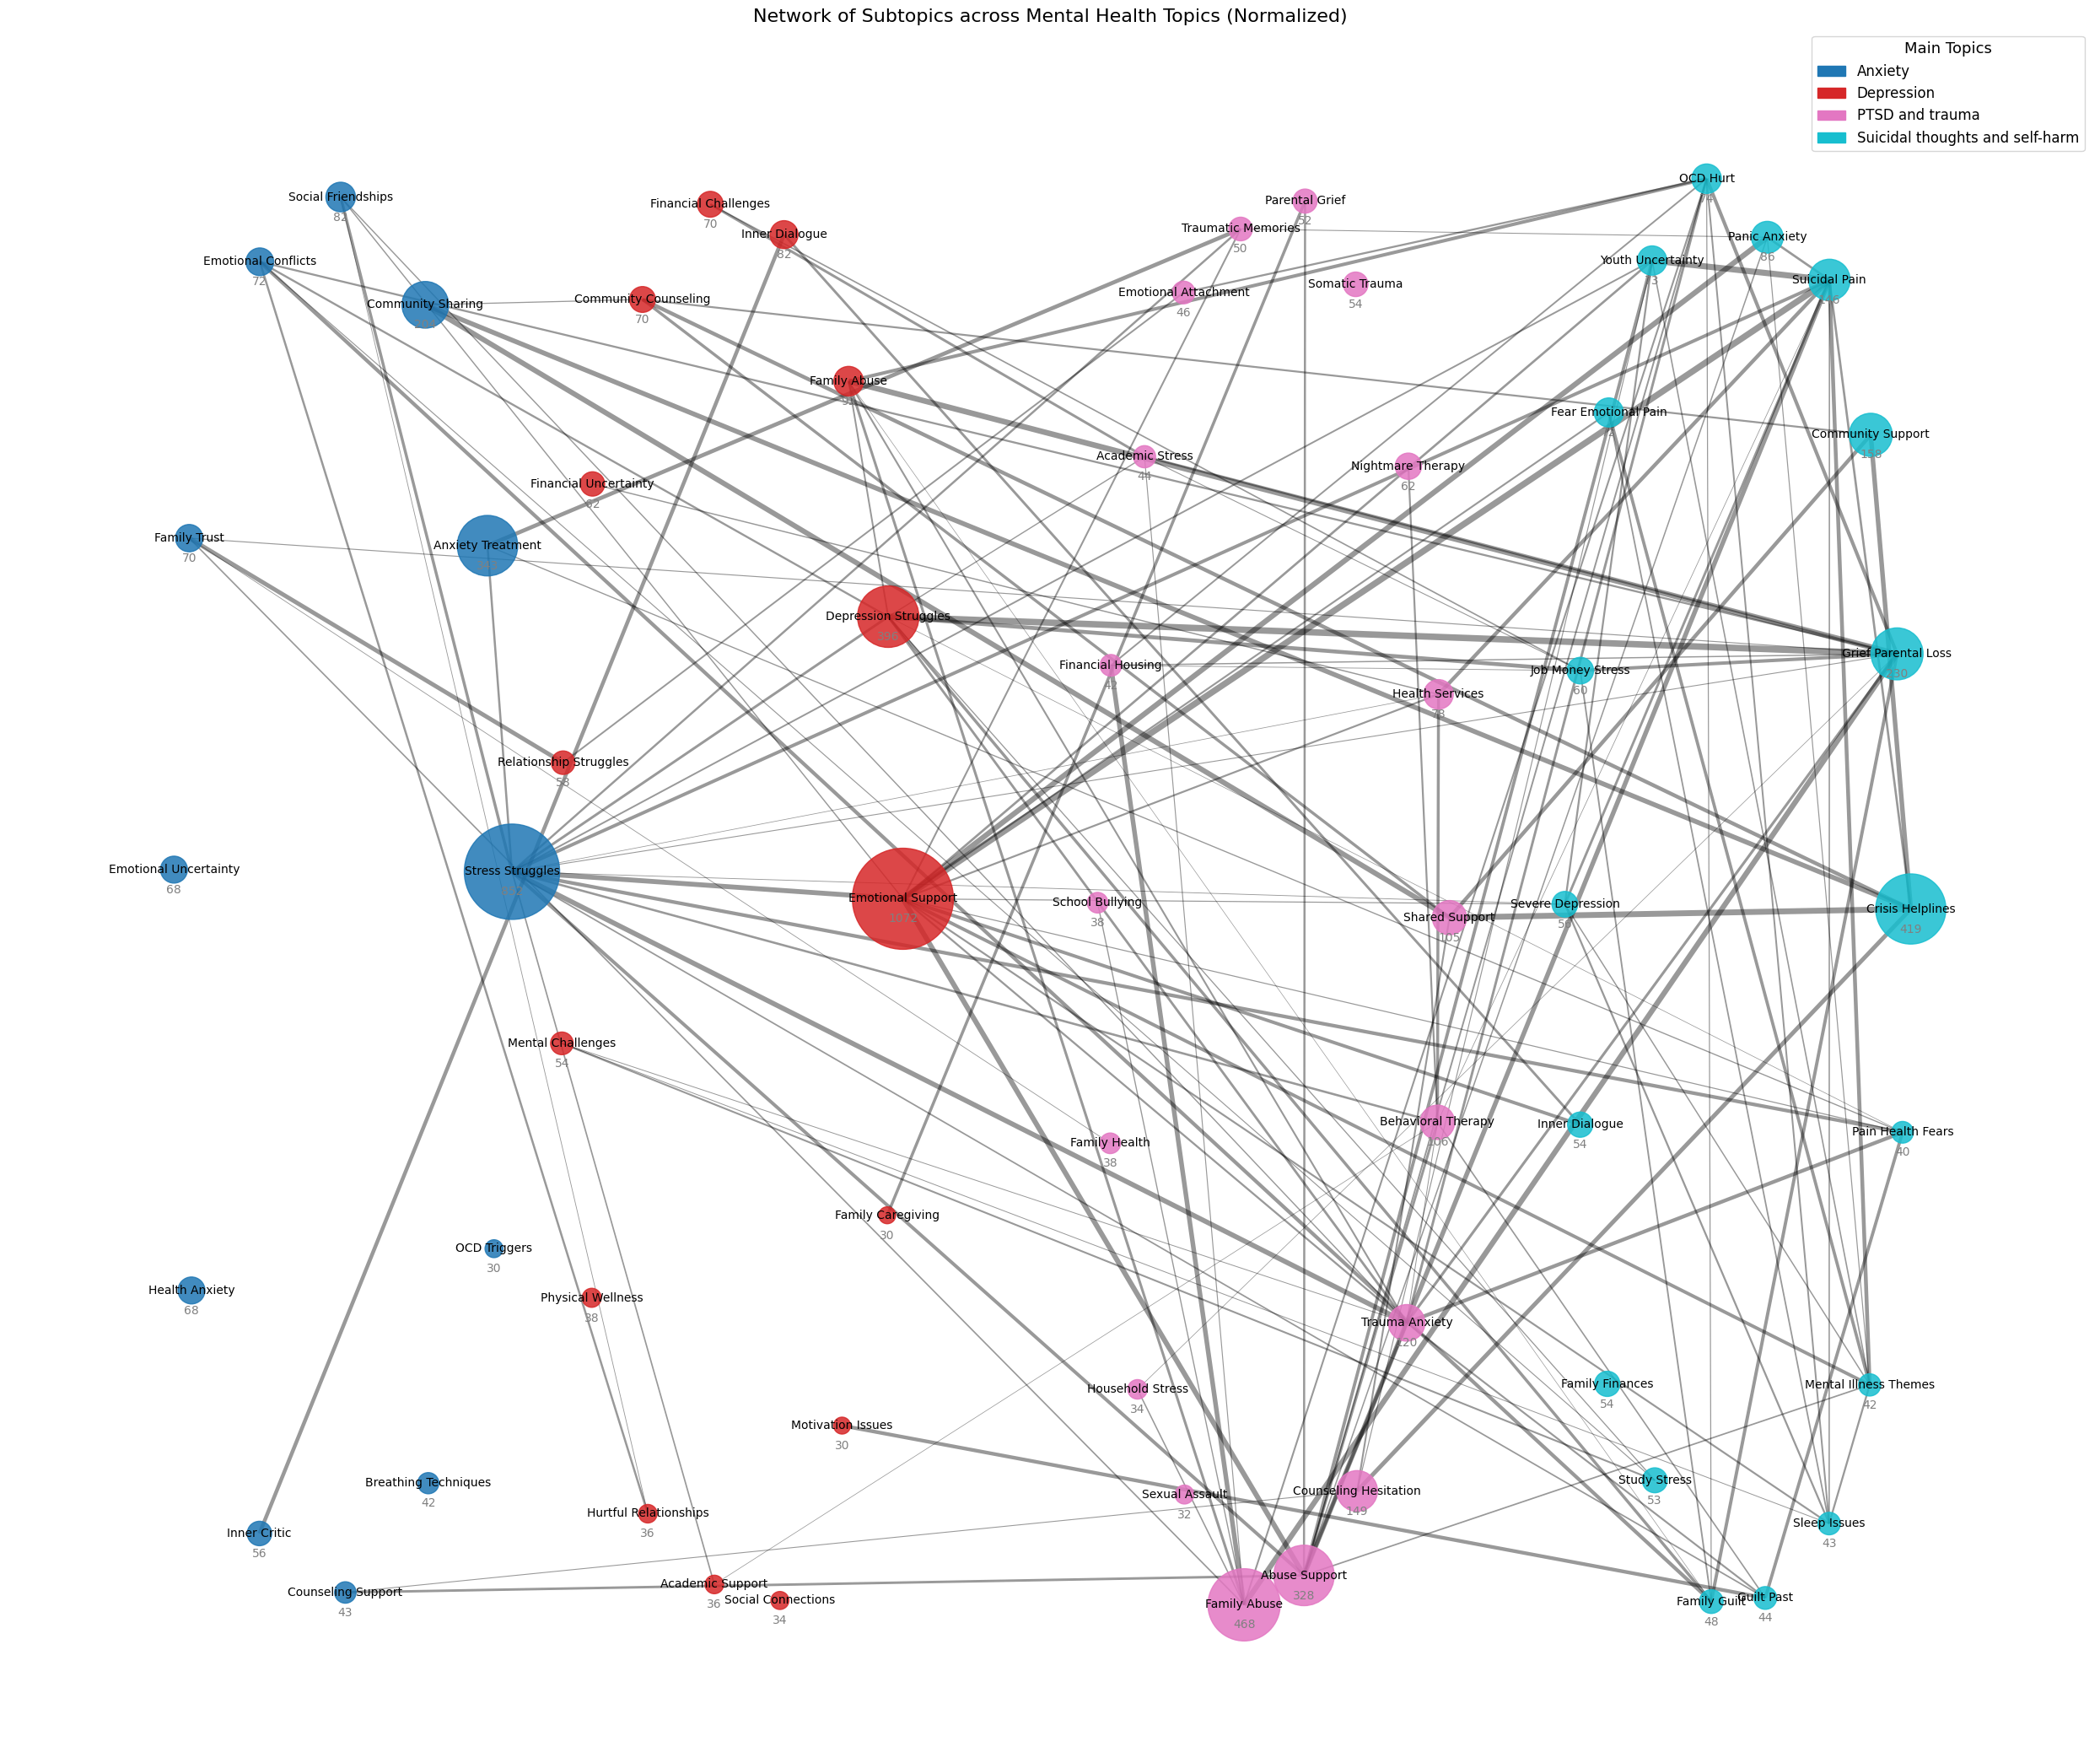

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict



def load_model_and_subtopics(platform, label, custom_names):
    """Load BERTopic model and subtopic info with topic embeddings."""
    path = os.path.join(os.getcwd(), 'data', f'{platform}_data', 'berttopic_label', label)
    try:
        topic_model = BERTopic.load(os.path.join(path, f'{label}_berttopic'))
    except Exception as e:
        print(f"Error loading model for label '{label}': {e}")
        return []
    
    # Get topic assignments and info
    topic_info = topic_model.get_topic_info()
    topic_keywords = {t: topic_model.get_topic(t) for t in topic_info.Topic if t != -1}
    doc_counts = topic_info.set_index("Topic")["Count"].to_dict()
    # Total number of documents assigned to this label (excluding outliers)
    total_label_docs = sum([count for tid, count in doc_counts.items() if tid != -1])
    
    
    # Get topic embeddings (excluding -1 if present)
    topic_embeddings = topic_model.topic_embeddings_
    topic_ids = sorted([t for t in topic_keywords.keys()])  # Only valid topics
    if len(topic_embeddings) != len(topic_info):
        print(f"Warning: Mismatch between topic embeddings ({len(topic_embeddings)}) and topics ({len(topic_info)}) for label '{label}'.")
    
    subtopics = []
    for topic_id in topic_ids:
        keywords = [(kw, score) for kw, score in topic_keywords[topic_id]]
        doc_indices = [i for i, t in enumerate(topic_model.topics_) if t == topic_id]
        if not doc_indices:
            print(f"Warning: No documents assigned to topic {topic_id} in label '{label}'.")
            continue
        # Map topic_id to embedding index (assuming embeddings align with topic IDs)
        embedding_idx = topic_id + 1 if topic_id >= 0 else 0  # Adjust for -1 if present
        if embedding_idx >= len(topic_embeddings):
            print(f"Warning: No embedding for topic {topic_id} in label '{label}'.")
            continue
        subtopics.append({
            'model_label': label,
            'topic_id': topic_id,
            'name': custom_names.get(topic_id, f"{label}_{topic_id}"),
            'keywords': keywords,
            'doc_indices': doc_indices,
            'doc_count': doc_counts.get(topic_id, 0),
            'embedding': topic_embeddings[embedding_idx],
            'total_label_docs': total_label_docs
        })
    
    return subtopics

def network_vis(platform, labels, custom_names_dict, sim_threshold=0.9):
    all_subtopics = []
    
    for label in labels:
        custom_names = custom_names_dict.get(label, {})
        subtopics = load_model_and_subtopics(platform, label, custom_names)
        if not subtopics:
            print(f"Skipping label '{label}' due to loading issues.")
            continue
        all_subtopics.extend(subtopics)
    
    if not all_subtopics:
        print("Error: No subtopics available for visualization.")
        return nx.Graph()
    
    embeddings = np.array([t['embedding'] for t in all_subtopics])
    sim_matrix = cosine_similarity(embeddings)
    




    G = nx.Graph()
    cmap = get_cmap("tab10", len(labels))
    label_color = {label: cmap(i) for i, label in enumerate(labels)}
    
    # Add nodes with normalized sizes
    for idx, topic in enumerate(all_subtopics):
        relative_size = topic['doc_count'] / topic['total_label_docs']
        G.add_node(
            idx,
            label=topic['model_label'],
            name=topic['name'],
            keywords=', '.join([kw for kw, _ in topic['keywords'][:5]]),
            size=relative_size,
            true_doc_count=topic['doc_count'],
            color=label_color[topic['model_label']],
        )
    


    # Add edges based on similarity
    min_sim, max_sim = np.inf, -np.inf
    for i in range(len(all_subtopics)):
        for j in range(i + 1, len(all_subtopics)):
            sim = sim_matrix[i, j]
            if sim >= sim_threshold:
                G.add_edge(i, j, weight=sim)
                min_sim = min(min_sim, sim)
                max_sim = max(max_sim, sim)
    






    # Graph layout clustering by main topic
    pos = {}
    horizontal_scale = 6  # horizontal separation
    vertical_scale = 3  # Scale vertical coordinates
    np.random.seed()  # For reproducible perturbations
    for i, label in enumerate(labels):
        nodes = [n for n, d in G.nodes(data=True) if d["label"] == label]
        subgraph = G.subgraph(nodes)
        # Dynamic offset based on number of nodes
        offset_step = 9.0 * (len(nodes) / 10.0)
        group_spacing = 6.0
        sub_pos = nx.circular_layout(subgraph, scale=1.0)
        for k in sub_pos:
            # Apply scaling for elliptical shape
            sub_pos[k][0] *= horizontal_scale
            sub_pos[k][1] *= vertical_scale
            # Add slight random perturbation for irregular circle
            sub_pos[k][0] += np.random.uniform(-0.15, 0.15)
            sub_pos[k][1] += np.random.uniform(-0.15, 0.15)
            # Shift by group offset
            sub_pos[k][0] += i * offset_step
            # sub_pos[k][0] += i * group_spacing
        pos.update(sub_pos)

    # Draw the graph
    plt.figure(figsize=(25, 21))
    
    node_sizes = [G.nodes[n]['size'] * 15000 for n in G.nodes]  # normalized & scaled
    node_colors = [G.nodes[n]['color'] for n in G.nodes]
    
    if G.edges:
        edge_weights = [((G[u][v]['weight'] - min_sim) / (max_sim - min_sim + 1e-6)) * 5 + 0.5 for u, v in G.edges]
    else:
        edge_weights = []

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85)
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.4)
    nx.draw_networkx_labels(G, pos, labels={n: G.nodes[n]['name'] for n in G.nodes}, font_size=10)
    
    # Show doc counts as tooltips in title if needed
    for node, (x, y) in pos.items():
        plt.text(x, y - 0.1, f"{G.nodes[node]['true_doc_count']}", fontsize=10, ha='center', color='gray')

    legend_handles = [
        mpatches.Patch(color=label_color[label], label=label)
        for label in labels
    ]
    plt.legend(
        handles=legend_handles,
        loc="upper right",
        fontsize=12,
        title="Main Topics",
        title_fontsize=13
    )

    plt.title("Network of Subtopics across Mental Health Topics (Normalized)", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    return G


# Define custom names
custom_names_dict = {
    "Anxiety": {
        -1: "Sleep Support",
        0: "Stress Struggles",
        1: "Anxiety Treatment",
        2: "Community Sharing",
        3: "Social Friendships",
        4: "Emotional Conflicts",
        5: "Family Trust",
        6: "Emotional Uncertainty",
        7: "Health Anxiety",
        8: "Inner Critic",
        9: "Counseling Support",
        10: "Breathing Techniques",
        11: "OCD Triggers"
    },
    "Depression": {
        -1: "Hopeful Friendships",
        0: "Emotional Support",
        1: "Depression Struggles",
        2: "Family Abuse",
        3: "Inner Dialogue",
        4: "Financial Challenges",
        5: "Community Counseling",
        6: "Financial Uncertainty",
        7: "Relationship Struggles",
        8: "Mental Challenges",
        9: "Physical Wellness",
        10: "Hurtful Relationships",
        11: "Academic Support",
        12: "Social Connections",
        13: "Motivation Issues",
        14: "Family Caregiving"
    },
    "PTSD and trauma": {
        -1: "PTSD Experiences",
        0: "Family Abuse",
        1: "Abuse Support",
        2: "Counseling Hesitation",
        3: "Trauma Anxiety",
        4: "Behavioral Therapy",
        5: "Shared Support",
        6: "Health Services",
        7: "Nightmare Therapy",
        8: "Somatic Trauma",
        9: "Parental Grief",
        10: "Traumatic Memories",
        11: "Emotional Attachment",
        12: "Academic Stress",
        13: "Financial Housing",
        14: "School Bullying",
        15: "Family Health",
        16: "Household Stress",
        17: "Sexual Assault"
    },
    "Suicidal thoughts and self-harm": {  
        -1: "Depression Therapy",
        0: "Crisis Helplines",
        1: "Grief Parental Loss",
        2: "Community Support",
        3: "Suicidal Pain",
        4: "Panic Anxiety",
        5: "OCD Hurt",
        6: "Youth Uncertainty",
        7: "Fear Emotional Pain",
        8: "Job Money Stress",
        9: "Severe Depression",
        10: "Inner Dialogue",
        11: "Family Finances",
        12: "Study Stress",
        13: "Family Guilt",
        14: "Guilt Past",
        15: "Sleep Issues",
        16: "Mental Illness Themes",
        17: "Pain Health Fears"
    }
}

# Run the visualization
platform = "beyondblue"
labels = ["Anxiety", "Depression","PTSD and trauma", "Suicidal thoughts and self-harm"]
G = network_vis(platform, labels, custom_names_dict, sim_threshold=0.995)
